In [250]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

RANDOM_STATE= 8

In [251]:
# create moons dataset with 1000 samples
X, y= make_moons(n_samples= 1000, 
                 shuffle= True, 
                 noise= 0.2,
                 random_state= RANDOM_STATE, 
                 )

print(X.shape, y.shape)

(1000, 2) (1000,)


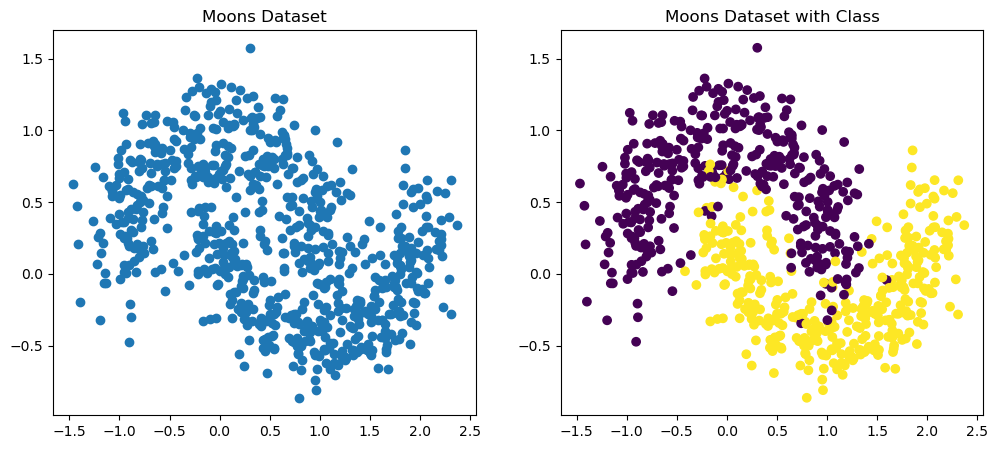

In [252]:
torch.manual_seed(8)

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size= 0.25, random_state= RANDOM_STATE
)

# visualize the train set
fig= plt.figure(figsize= (12, 5))

ax= fig.add_subplot(1, 2, 1)
ax.scatter(X_train[:, 0], X_train[:, 1])
ax.set_title('Moons Dataset')

ax= fig.add_subplot(1, 2, 2)
ax.scatter(X_train[:, 0], X_train[:, 1], c= y_train)
ax.set_title('Moons Dataset with Class')

plt.show()

In [253]:
# scale dataset

scaler= StandardScaler()
scaler.fit(X_train)

X_train_norm= scaler.transform(X_train)
X_test_norm= scaler.transform(X_test)

In [254]:
# cast dataset to tensor

X_train_norm_t= torch.from_numpy(X_train_norm).float()
X_test_norm_t= torch.from_numpy(X_test_norm).float()

y_train_t= torch.from_numpy(y_train).float()
y_test_t= torch.from_numpy(y_test).float()

In [255]:
# check dataset shape

print(X_train_norm_t.shape, X_test_norm_t.shape)
print(y_train_t.shape, y_test_t.shape)

torch.Size([750, 2]) torch.Size([250, 2])
torch.Size([750]) torch.Size([250])


In [256]:
# add dataset to dataloader

train_ds= TensorDataset(X_train_norm_t, y_train_t)
batch_size= 8
train_dl= DataLoader(train_ds, 
                     batch_size= batch_size, 
                     shuffle= True, 
                     drop_last= True)

In [257]:
# nn model

class Model(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()

        self.layer1= nn.Linear(input_size, hidden_size)
        self.activ1= nn.ReLU()
        
        self.layer2= nn.Linear(hidden_size, hidden_size)
        self.activ2= nn.ReLU()
        
        self.layer3= nn.Linear(hidden_size, output_size)
        self.activ3= nn.Sigmoid()

    def forward(self, x):
        x= self.layer1(x)
        x= self.activ1(x)
        x= self.layer2(x)
        x= self.activ2(x)
        x= self.layer3(x)
        x= self.activ3(x)
        return x
    
input_size= X_test_norm_t.shape[1] # num features
hidden_size= 32
output_size= 1
learning_rate= 0.001
num_epochs= 100

model= Model(input_size, hidden_size, output_size)
loss_fn= nn.BCELoss()
optimizer= torch.optim.Adam(model.parameters(), lr= learning_rate)

In [258]:
# training

# define loss and acc list
loss_history= [0] * num_epochs
acc_history= [0] * num_epochs

for epoch in range(num_epochs):

    for x_batch, y_batch in train_dl:

        # get prediction
        y_pred_proba= model(x_batch)

        # flatten the pred to match the shape of y_batch
        y_pred_proba_flat= y_pred_proba.flatten()

        # get loss
        loss= loss_fn(y_pred_proba_flat, y_batch)

        # backpropagate gradient
        loss.backward()

        # update model params
        optimizer.step()

        # reset gradients
        optimizer.zero_grad()

        # get the lossof this batch
        batch_loss= loss.item() * y_batch.size(0)
        loss_history[epoch] += batch_loss

        # get prediction
        # get accuracy
        y_pred= y_pred_proba_flat.detach().round()
        batch_acc= (y_pred == y_batch).float()
        acc_history[epoch] += batch_acc.sum()
    
    # avg loss and avg acc for the current epoch
    loss_history[epoch] /= len(train_dl.dataset)
    acc_history[epoch] /= len(train_dl.dataset)

    # every 20 epochs, print loss 
    if epoch % 20 == 0:
        print(f'epoch {epoch}, loss : {loss}, acc : {acc_history[epoch]}')

epoch 0, loss : 0.5265864133834839, acc : 0.7333333492279053
epoch 20, loss : 0.015626193955540657, acc : 0.9586666822433472
epoch 40, loss : 0.0030171312391757965, acc : 0.9546666741371155
epoch 60, loss : 0.032661519944667816, acc : 0.9586666822433472
epoch 80, loss : 0.0005843436229042709, acc : 0.9559999704360962


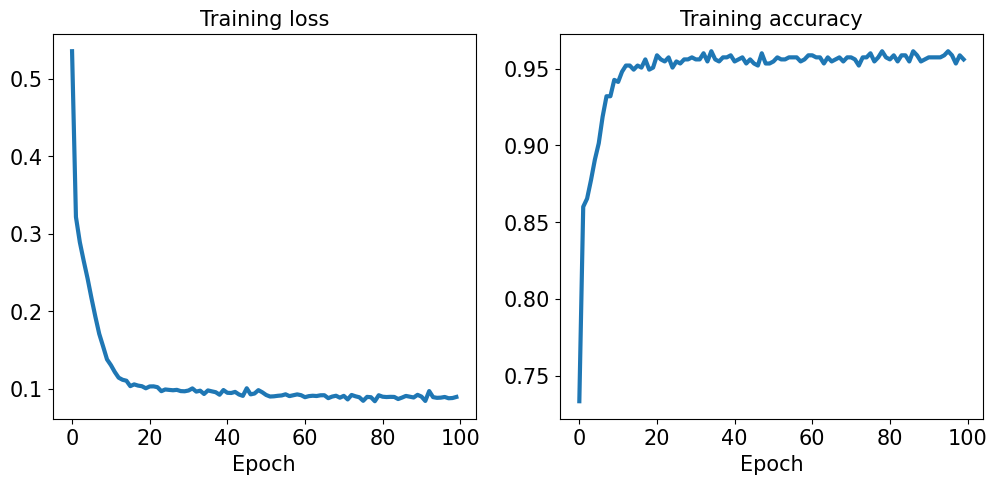

In [259]:
# visualize loss and accuracy

fig = plt.figure(figsize=(12, 5))

ax = fig.add_subplot(1, 2, 1)
ax.plot(loss_history, lw=3)

ax.set_title('Training loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(acc_history, lw=3)

ax.set_title('Training accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

plt.show()

In [260]:
# predict test set

y_pred_proba= model(X_test_norm_t)
y_pred= y_pred_proba.flatten().detach().round()

correct_pred= (y_pred == y_test_t).float()
acc= correct_pred.mean()

print(f'Test Acc.: {acc: .5f}')

Test Acc.:  0.97200


In [261]:
# create array to visualize false prediction 

true_pred_class0= (y_pred == y_test_t) & (y_pred == 0)
true_pred_class1= (y_pred == y_test_t) & (y_pred == 1)

y_pred_false = np.select(
    condlist= [true_pred_class0, true_pred_class1], 
    choicelist= [0, 2], 
    default= 1
)

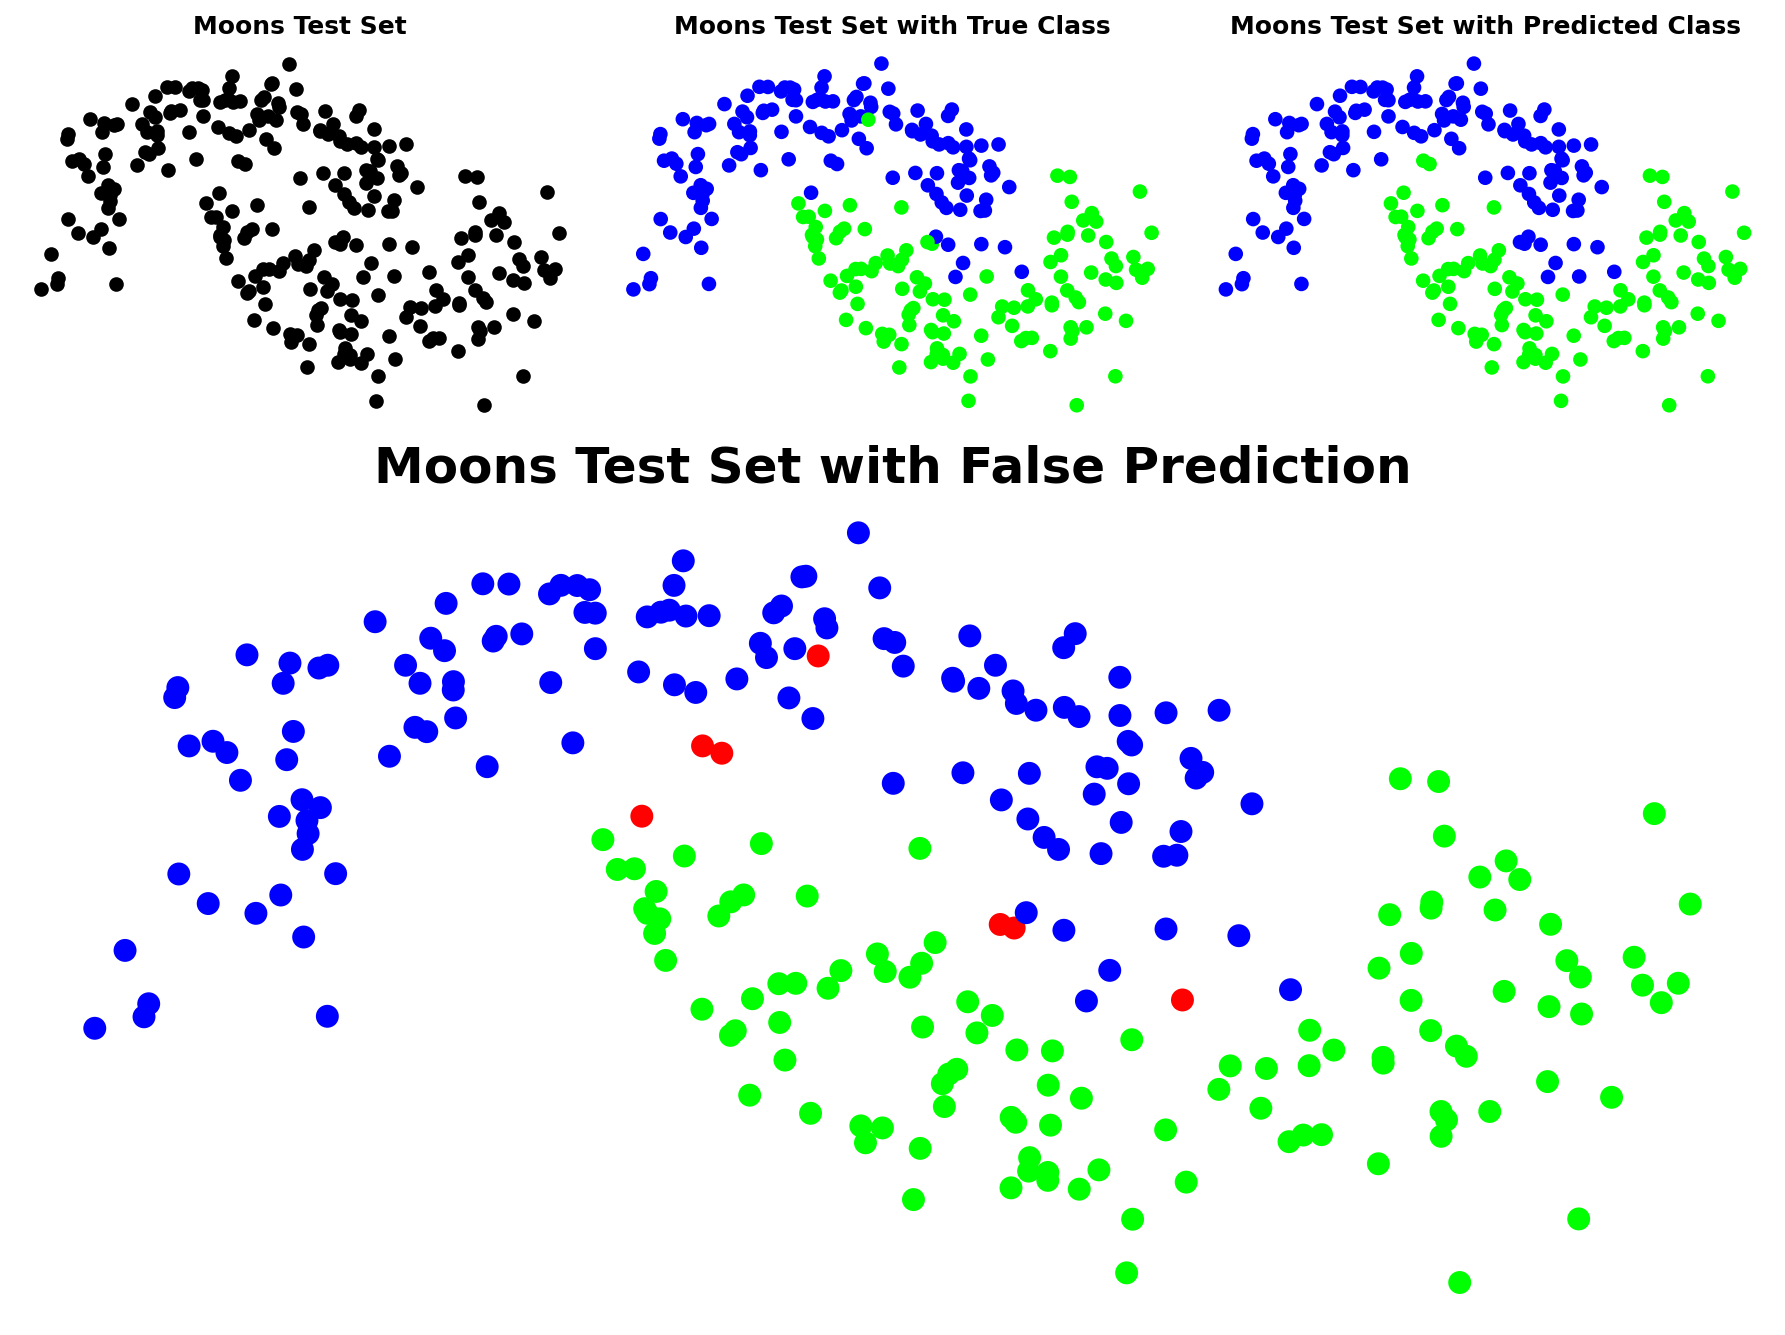

In [264]:
fig= plt.figure(figsize= (12, 9), dpi= 150)

ax1= fig.add_subplot(3, 3, 1)
ax1.scatter(X_test_norm_t[:, 0], 
           X_test_norm_t[:, 1],
           c= 'black')
ax1.set_title('Moons Test Set', fontweight= 'bold')

ax2= fig.add_subplot(3, 3, 2)
ax2.scatter(X_test_norm_t[:, 0], 
           X_test_norm_t[:, 1], 
           cmap= 'brg',
           c= y_test)
ax2.set_title('Moons Test Set with True Class', fontweight= 'bold')

ax3= fig.add_subplot(3, 3, 3)
ax3.scatter(X_test_norm_t[:, 0], 
           X_test_norm_t[:, 1], 
           cmap= 'brg',
           c= y_pred)
ax3.set_title('Moons Test Set with Predicted Class', fontweight= 'bold')

ax4= fig.add_subplot(3, 1, (2, 3))
ax4.scatter(X_test_norm_t[:, 0], 
           X_test_norm_t[:, 1], 
           cmap= 'brg',
           c= y_pred_false, 
           s= 100)
ax4.set_title('Moons Test Set with False Prediction', 
             fontweight= 'bold', 
             fontsize= 24)

# set spines invisible
for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines[['top', 'bottom', 'left', 'right']].set_visible(False)

fig.tight_layout()
plt.show()